# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

In [2]:
np.random.seed(99)

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [3]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [4]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    print(R)
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [0 0 0 3]
 [0 0 0 0]
 [0 1 2 0]]
check?  0
dofk2  1
-0.5

[[0 0 3 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 1 0 0]]
-0.5  0
check?  0
dofk2  1
0.0

[[0 0 3 0]
 [0 0 0 0]
 [0 2 1 0]
 [0 0 0 0]]
0.0  1
check?  0
dofk2  0


In [5]:
def smooth_vals(points, neighbors):
    '''
    reduce number of points by picking subsets and their mean
    
    '''
    
    smoothed_points = []
    
    for i in range(0, len(points), neighbors):

        smoothed_points.append(np.mean(points[i: i + neighbors]))
        
        
    return smoothed_points

def epsilon_greedy(allowed_actions, action_values, e):
    
    '''
    INPUT:
    allowed_actions: numpy array of 1's and 0's 
    action_values: numpy array of values that give associated 
    e : float  between 0 and 1
    
    
    FUNCTION:
    returns max in allowed_actions with prob 1 - e
    returns random value from allowed_action with prob e
    
    '''
    
    assert e >= 0 and e <= 1
    allowed_actions = allowed_actions[:,0]
    
    allowed_action_indices = np.argwhere(allowed_actions > 0)

    
    if np.random.uniform(0,1) <= e:
        allowed_action_index = np.random.randint(0,len(allowed_action_indices))

    else:
        allowed_action_index = np.argmax(action_values[allowed_action_indices])
  
    
    return allowed_action_indices[allowed_action_index][0]

    
def relu(input_vector):
    '''
    Input: input_vector is a numpy array
    
    FUNCTION:
    returns max(0,x_i) for all i; where x_i is the element in the vector 
    
    '''
    
    return np.maximum(0, input_vector)

def relu_derv(input_vector):
    
    '''
    Input: input_vector is a numpy array
    
    FUNCTION:
    returns relu derv for each element in vector 
    
    '''
    
    return np.where(input_vector > 0, 1, 0)
    

class DQN():
    
    def __init__(self,list_of_nodes, activation_hidden = False):
        '''
        INPUT:
        list_of_nodes: iterable obj containing num of nodes at each layer; 
                       first layer should correspond to input; last layer should correspond to output
                       e.g [100, 200, 50]

        activation_hidden: boolean; whether or not to apply RELU ( the only implemented activation function) for hidden layers
        activation_last:   boolean; whether or not to apply RELU ( the only implemented activation function) for last layer
        '''
        self.weights = []
        self.activations_hidden = activation_hidden
        self.stored_vals = [] # These will be used for calc. backprog later
        for i in range(len(list_of_nodes) - 1):
            self.weights.append(np.random.uniform(-1,1,(list_of_nodes[i], list_of_nodes[i + 1])))
            self.stored_vals.append([])
                 
            
    def feed_forward(self,input_vector, grad = True):
        
        self.stored_vals[0] = [input_vector, input_vector]
        
        for i in range(len(self.weights[:-1])):
                 
            input_vector = np.matmul(input_vector, self.weights[i])
            
            if grad:
                self.stored_vals[i + 1] = [input_vector, input_vector]
            if self.activations_hidden:
                input_vector = relu(input_vector)
                
            if grad:
                self.stored_vals[i + 1][1] = input_vector
            
        
        input_vector = np.matmul(input_vector, self.weights[-1])
                 
        
        return input_vector
                 
    
    def back_prop(self, loss_vector, chosen_action_pos, learning_rate):
        
        self.weight_gradients = []
        for i in self.weights:
            self.weight_gradients.append(np.zeros(i.shape))
        
        temp = loss_vector
        self.weight_gradients[-1][:, chosen_action_pos] = np.dot(temp, self.stored_vals[-1][1])
        
        for i in range(len(self.weight_gradients) - 1, 0, -1):
            t = relu_derv(self.stored_vals[i][0])
            relu_der = np.multiply(np.identity(t.shape[0]), t) 

            if i == len(self.weight_gradients) - 1:
                temp = temp * np.matmul(self.weights[i][:,chosen_action_pos],relu_der)
            else:
                temp = np.matmul(temp, np.matmul(self.weights[i][:,chosen_action_pos],relu_der))
                
            temp = np.reshape(temp,(1, temp.size))
            
            t = self.stored_vals[i-1][1]
            t = np.reshape(t,(1, t.size))
            
            self.weight_gradients[i-1] = np.matmul(temp.T, t).T
        
        
        for i in range(len(self.weights)):
            
            self.weights[i] = self.weights[i] + learning_rate * self.weight_gradients[i] #(1 - learning_rate) * 
               

## Random Agents Playing each other

In [73]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 
rand_rewards, rand_moves, rand_wins = [], [], []
S,X,allowed_a=env.Initialise_game()
N_episodes=15000

for n in range(N_episodes):
    
    reward_per_ep = 0.
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        reward_per_ep += R
        
        
        if Done:
            rand_rewards.append(reward_per_ep)
            rand_moves.append(i)
            if(R>0):
                rand_wins.append(1)
            else:
                rand_wins.append(0)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)


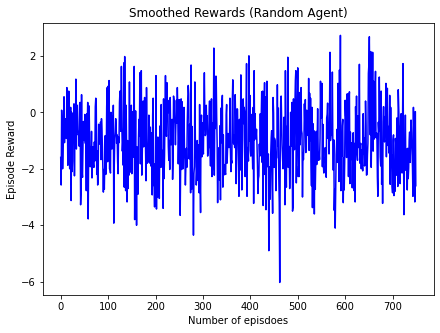

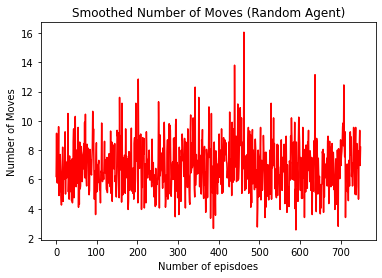

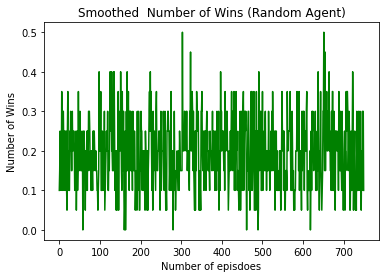

In [74]:
plt.figure(figsize = (7,5))
plt.title('Smoothed Rewards (Random Agent)')
plt.ylabel('Episode Reward')
plt.xlabel('Number of episdoes')
smoothed_rand_rewards = smooth_vals(rand_rewards,20)
plt.plot(smoothed_rand_rewards, color = 'b')
plt.show()

plt.title('Smoothed Number of Moves (Random Agent)')
plt.ylabel('Number of Moves')
plt.xlabel('Number of episdoes')
smoothed_rand_moves = smooth_vals(rand_moves,20)
plt.plot(smoothed_rand_moves, color = 'r')
plt.show()


plt.title('Smoothed  Number of Wins (Random Agent)')
plt.ylabel('Number of Wins')
plt.xlabel('Number of episdoes')
smoothed_rand_wins = smooth_vals(rand_wins,20)
plt.plot(smoothed_rand_wins, color = 'g')
plt.show()

## SARSA

In [75]:
S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...

list_of_nodes = [N_in, N_h, N_a]

# USING TWO DIFFERENT NETWORKS TO STABILIZE THE ALGORITHMS; 
target_nn  = DQN(list_of_nodes, True)  # Target NN provides estimates of targets and is frozen mostly; it is updated slowly to keep training stable 

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 15000 # THE NUMBER OF GAMES TO BE PLAYED 100000

In [76]:
sarsa_rewards, sarsa_moves, sarsa_wins = [], [], []
for n in range(N_episodes):
    
    reward_per_ep = 0.

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        
        

        
        action_vals = target_nn.feed_forward(X)
        a_agent = epsilon_greedy(allowed_a, action_vals, epsilon_f)             
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent) # after taking step we have the reward
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            delta_t = R - action_vals[a_agent]
            target_nn.back_prop(delta_t, a_agent, eta)
            sarsa_moves.append(i)
            reward_per_ep += R
            sarsa_rewards.append(reward_per_ep)
            if(R>0):
                sarsa_wins.append(1)
            else:
                sarsa_wins.append(0)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else:

            future_action_vals = target_nn.feed_forward(X_next, False)
            future_a_agent = epsilon_greedy(allowed_a_next, future_action_vals, epsilon_f)
            delta_t = R + (gamma*future_action_vals[future_a_agent]) - action_vals[a_agent]
            target_nn.back_prop(delta_t, a_agent, eta)
            reward_per_ep += R
            
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


        
        
    
    

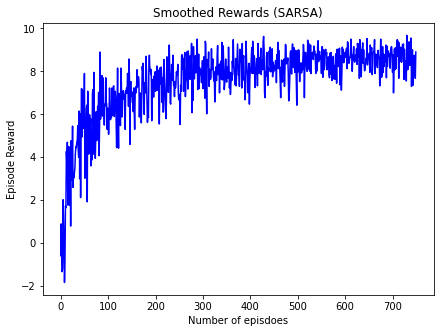

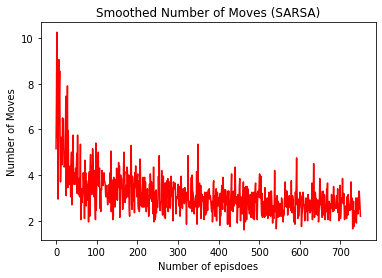

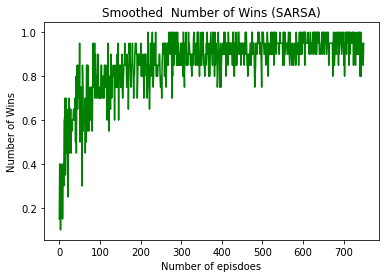

In [77]:
plt.figure(figsize = (7,5))
plt.title('Smoothed Rewards (SARSA)')
plt.ylabel('Episode Reward')
plt.xlabel('Number of episdoes')
smoothed_rand_rewards = smooth_vals(sarsa_rewards,20)
plt.plot(smoothed_rand_rewards, color = 'b')
plt.show()

plt.title('Smoothed Number of Moves (SARSA)')
plt.ylabel('Number of Moves')
plt.xlabel('Number of episdoes')
smoothed_rand_moves = smooth_vals(sarsa_moves,20)
plt.plot(smoothed_rand_moves, color = 'r')
plt.show()


plt.title('Smoothed  Number of Wins (SARSA)')
plt.ylabel('Number of Wins')
plt.xlabel('Number of episdoes')
smoothed_rand_wins = smooth_vals(sarsa_wins,20)
plt.plot(smoothed_rand_wins, color = 'g')
plt.show()

## Tuning $\beta$ and $\gamma$ Parameters

In [78]:
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...
list_of_nodes = [N_in, N_h, N_a]

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 10000 # THE NUMBER OF GAMES TO BE PLAYED 100000

In [79]:
gamma_rewards = [] 
gammas = np.array([i for i in range(0,11,2)])/10

for g in gammas:    
        S,X,allowed_a=env.Initialise_game()
        target_nn  = DQN(list_of_nodes, True)
        rewards, moves, wins = [], [], []
        for n in range(N_episodes):

            reward_per_ep = 0.

            epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
            Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
            i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

            S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

            while Done==0:                           ## START THE EPISODE




                action_vals = target_nn.feed_forward(X)
                a_agent = epsilon_greedy(allowed_a, action_vals, epsilon_f)             
                S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent) # after taking step we have the reward


                ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
                if Done==1:
                    delta_t = R - action_vals[a_agent]
                    target_nn.back_prop(delta_t, a_agent, eta)
                    moves.append(i)
                    reward_per_ep += R
                    rewards.append(reward_per_ep)
                    if(R>0):
                        wins.append(1)
                    else:
                        wins.append(0)
                    break

                # IF THE EPISODE IS NOT OVER...
                else:

                    future_action_vals = target_nn.feed_forward(X_next, False)
                    future_a_agent = epsilon_greedy(allowed_a_next, future_action_vals, epsilon_f)
                    delta_t = R + (gamma*future_action_vals[future_a_agent]) - action_vals[a_agent]
                    target_nn.back_prop(delta_t, a_agent, eta)
                    reward_per_ep += R



                # NEXT STATE AND CO. BECOME ACTUAL STATE...     
                S=np.copy(S_next)
                X=np.copy(X_next)
                allowed_a=np.copy(allowed_a_next)

                i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
        gamma_rewards.append([rewards, moves, wins])

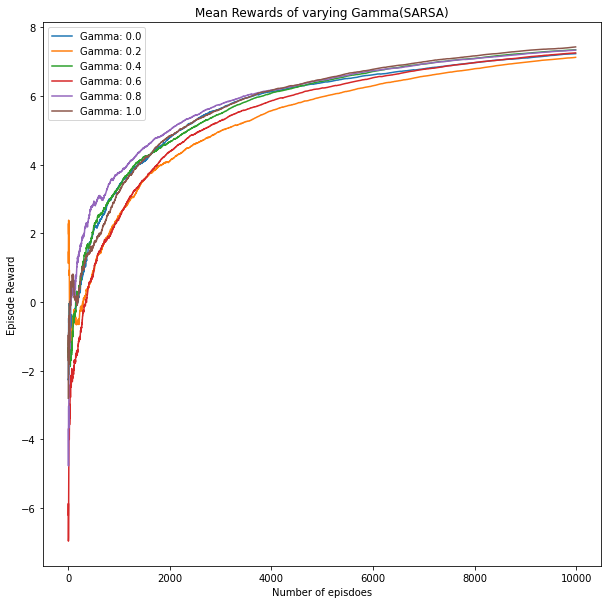

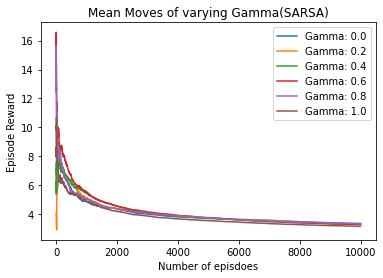

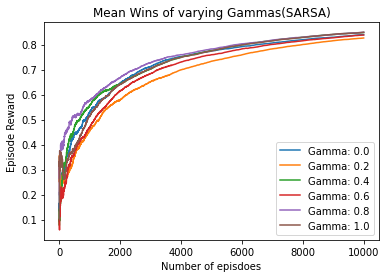

In [98]:
# take moving average of sarsa to get smooth plot
# use a for loop to label plots with beta/gamma values

plt.figure(figsize = (10,10))

for i in range(len(gammas)):
    smoothed_rand_rewards = [np.mean(gamma_rewards[i][0][:j]) for j in range(10,len(gamma_rewards[i][0]))]           
                          
    plt.title('Mean Rewards of varying Gamma(SARSA)')
    plt.ylabel('Episode Reward')
    plt.xlabel('Number of episdoes')
    plt.plot(smoothed_rand_rewards, label = 'Gamma: ' + str(gammas[i]))
plt.legend()
plt.show()


for i in range(len(gammas)):

    smoothed_rand_moves = [np.mean(gamma_rewards[i][1][:j]) for j in range(10, len(gamma_rewards[1][0]))]        
                          
    plt.title('Mean Moves of varying Gamma(SARSA)')
    plt.ylabel('Episode Reward')
    plt.xlabel('Number of episdoes')
    plt.plot(smoothed_rand_moves, label = 'Gamma: ' + str(gammas[i]))
plt.legend()
plt.show()

for i in range(len(gammas)):
    smoothed_rand_wins = [np.mean(gamma_rewards[i][2][:j]) for j in range(10, len(gamma_rewards[i][2]))]             
                          
    plt.title('Mean Wins of varying Gammas(SARSA)')
    plt.ylabel('Episode Reward')
    plt.xlabel('Number of episdoes')
    plt.plot(smoothed_rand_wins, label = 'Gamma: ' + str(gammas[i]))
plt.legend()
plt.show()

In [81]:
beta_rewards = [] 
betas = [beta * i for i in range(1,500,100)]

for b in betas:
        beta = b       
        S,X,allowed_a=env.Initialise_game()
        target_nn  = DQN(list_of_nodes, True)
        rewards, moves, wins = [], [], []
        for n in range(N_episodes):

            reward_per_ep = 0.

            epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
            Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
            i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

            S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

            while Done==0:                           ## START THE EPISODE




                action_vals = target_nn.feed_forward(X)
                a_agent = epsilon_greedy(allowed_a, action_vals, epsilon_f)             
                S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent) # after taking step we have the reward


                ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
                if Done==1:
                    delta_t = R - action_vals[a_agent]
                    target_nn.back_prop(delta_t, a_agent, eta)
                    moves.append(i)
                    reward_per_ep += R
                    rewards.append(reward_per_ep)
                    if(R>0):
                        wins.append(1)
                    else:
                        wins.append(0)
                    break

                # IF THE EPISODE IS NOT OVER...
                else:

                    future_action_vals = target_nn.feed_forward(X_next, False)
                    future_a_agent = epsilon_greedy(allowed_a_next, future_action_vals, epsilon_f)
                    delta_t = R + (gamma*future_action_vals[future_a_agent]) - action_vals[a_agent]
                    target_nn.back_prop(delta_t, a_agent, eta)
                    reward_per_ep += R



                # NEXT STATE AND CO. BECOME ACTUAL STATE...     
                S=np.copy(S_next)
                X=np.copy(X_next)
                allowed_a=np.copy(allowed_a_next)

                i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
        beta_rewards.append([rewards, moves, wins])

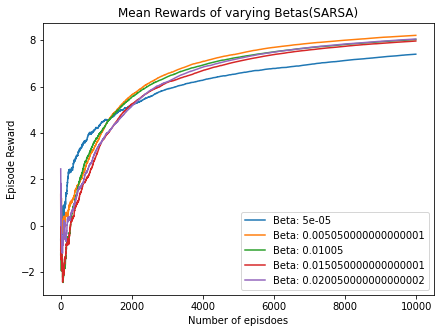

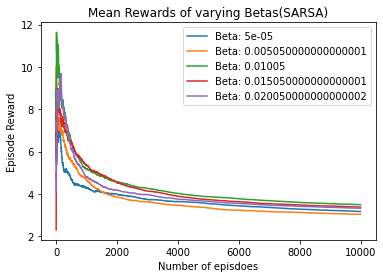

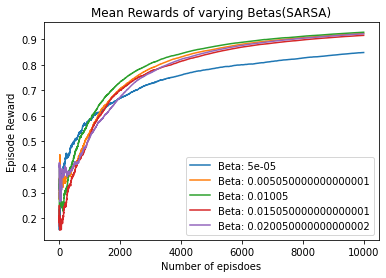

In [82]:
# take moving average of sarsa to get smooth plot
# use a for loop to label plots with beta/gamma values

plt.figure(figsize = (7,5))

for i in range(len(betas)):
    smoothed_rand_rewards = [np.mean(beta_rewards[i][0][:j]) for j in range(10,len(beta_rewards[i][0]))]           
                          
    plt.title('Mean Rewards of varying Betas(SARSA)')
    plt.ylabel('Episode Reward')
    plt.xlabel('Number of episdoes')
    plt.plot(smoothed_rand_rewards, label = 'Beta: ' + str(betas[i]))
plt.legend()
plt.show()


for i in range(len(betas)):

    smoothed_rand_moves = [np.mean(beta_rewards[i][1][:j]) for j in range(10, len(beta_rewards[1][0]))]        
                          
    plt.title('Mean Moves of varying Betas(SARSA)')
    plt.ylabel('Episode Reward')
    plt.xlabel('Number of episdoes')
    plt.plot(smoothed_rand_moves, label = 'Beta: ' + str(betas[i]))
plt.legend()
plt.show()

for i in range(len(betas)):
    smoothed_rand_wins = [np.mean(beta_rewards[i][2][:j]) for j in range(10, len(beta_rewards[i][2]))]             
                          
    plt.title('Mean Wins of varying Betas(SARSA)')
    plt.ylabel('Episode Reward')
    plt.xlabel('Number of episdoes')
    plt.plot(smoothed_rand_wins, label = 'Beta: ' + str(betas[i]))
plt.legend()
plt.show()

## Q - Learning Naive

In [83]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER O USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...

list_of_nodes = [N_in, N_h, N_a]

# USING TWO DIFFERENT NETWORKS TO STABILIZE THE ALGORITHMS; 
target_nn  = DQN(list_of_nodes, True)  # Target NN provides estimates of targets and is frozen mostly; it is updated slowly to keep training stable 
predict_nn = DQN(list_of_nodes, True)  # Predict NN is the one constantly learning q values and is more frequently updated

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

update_target_network = 1
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 15000 # THE NUMBER OF GAMES TO BE PLAYED 100000

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])





In [84]:
q_n_rewards, q_n_moves, q_n_wins = [], [], []

for n in range(N_episodes):
    
    reward_per_ep = 0.

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE

        
        action_vals = predict_nn.feed_forward(X)
        a_agent = epsilon_greedy(allowed_a, action_vals, epsilon_f)             
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent) # after taking step we have the reward
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            delta_t = R - action_vals[a_agent]
            predict_nn.back_prop(delta_t, a_agent, eta)
            q_n_moves.append(i)
            reward_per_ep += R
            q_n_rewards.append(reward_per_ep)
            if(R>0):
                q_n_wins.append(1)
            else:
                q_n_wins.append(0)
            break
        # IF THE EPISODE IS NOT OVER...
        else:

            future_action_vals = target_nn.feed_forward(X_next, False)
            future_a_agent = epsilon_greedy(allowed_a_next, future_action_vals, 0)
            
            # now we have the next action so we can choose the future action value 
            delta_t = R + (gamma*future_action_vals[future_a_agent]) - action_vals[a_agent]
            predict_nn.back_prop(delta_t, a_agent, eta) # store delta_t and a_agent since that is required
            reward_per_ep += R
            
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
        if i % update_target_network == 0:
            target_nn = predict_nn




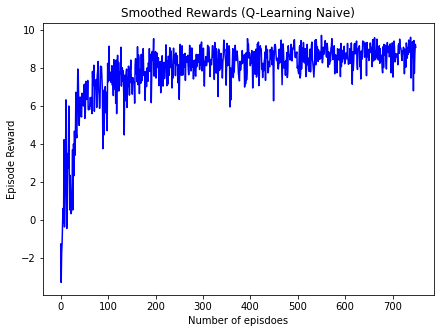

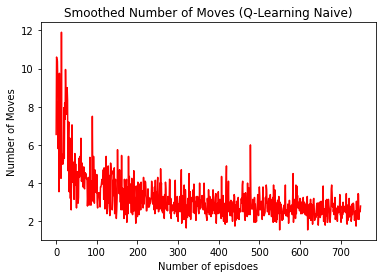

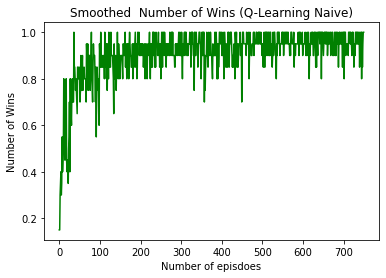

In [85]:
plt.figure(figsize = (7,5))
plt.title('Smoothed Rewards (Q-Learning Naive)')
plt.ylabel('Episode Reward')
plt.xlabel('Number of episdoes')
smoothed_rand_rewards = smooth_vals(q_n_rewards,20)
plt.plot(smoothed_rand_rewards, color = 'b')
plt.show()

plt.title('Smoothed Number of Moves (Q-Learning Naive)')
plt.ylabel('Number of Moves')
plt.xlabel('Number of episdoes')
smoothed_rand_moves = smooth_vals(q_n_moves,20)
plt.plot(smoothed_rand_moves, color = 'r')
plt.show()


plt.title('Smoothed  Number of Wins (Q-Learning Naive)')
plt.ylabel('Number of Wins')
plt.xlabel('Number of episdoes')
smoothed_rand_wins = smooth_vals(q_n_wins,20)
plt.plot(smoothed_rand_wins, color = 'g')
plt.show()

## Q - Learning Two Neural Networks

In [86]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER O USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...

list_of_nodes = [N_in, N_h, N_a]

# USING TWO DIFFERENT NETWORKS TO STABILIZE THE ALGORITHMS; 
target_nn  = DQN(list_of_nodes, True)  # Target NN provides estimates of targets and is frozen mostly; it is updated slowly to keep training stable 
predict_nn = DQN(list_of_nodes, True)  # Predict NN is the one constantly learning q values and is more frequently updated

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

update_target_network = 50
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 15000 # THE NUMBER OF GAMES TO BE PLAYED 100000

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])




In [87]:
q_t_rewards, q_t_moves, q_t_wins = [], [], []

for n in range(N_episodes):
    
    reward_per_ep = 0.

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE

        
        action_vals = predict_nn.feed_forward(X)
        a_agent = epsilon_greedy(allowed_a, action_vals, epsilon_f)             
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent) # after taking step we have the reward
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            delta_t = R - action_vals[a_agent]
            predict_nn.back_prop(delta_t, a_agent, eta)
            q_t_moves.append(i)
            reward_per_ep += R
            q_t_rewards.append(reward_per_ep)
            if(R>0):
                q_t_wins.append(1)
            else:
                q_t_wins.append(0)
            break
        # IF THE EPISODE IS NOT OVER...
        else:

            future_action_vals = target_nn.feed_forward(X_next, False)
            future_a_agent = epsilon_greedy(allowed_a_next, future_action_vals, 0)
            
            # now we have the next action so we can choose the future action value 
            delta_t = R + (gamma*future_action_vals[future_a_agent]) - action_vals[a_agent]
            predict_nn.back_prop(delta_t, a_agent, eta) # store delta_t and a_agent since that is required
            reward_per_ep += R
            
            
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
        if i % update_target_network == 0:
            target_nn = predict_nn



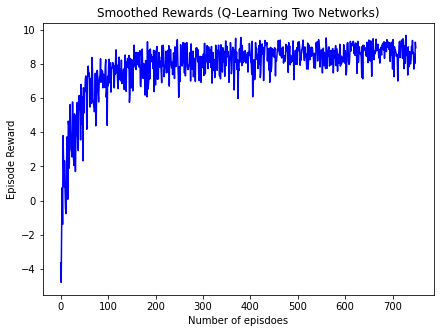

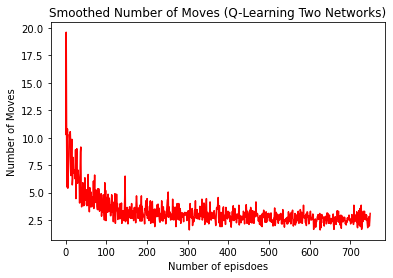

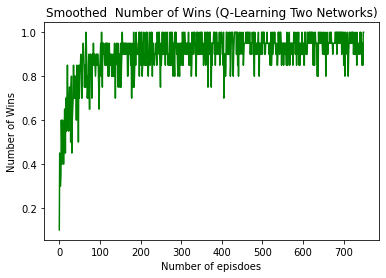

In [88]:
plt.figure(figsize = (7,5))
plt.title('Smoothed Rewards (Q-Learning Two Networks)')
plt.ylabel('Episode Reward')
plt.xlabel('Number of episdoes')
smoothed_rand_rewards = smooth_vals(q_t_rewards,20)
plt.plot(smoothed_rand_rewards, color = 'b')
plt.show()

plt.title('Smoothed Number of Moves (Q-Learning Two Networks)')
plt.ylabel('Number of Moves')
plt.xlabel('Number of episdoes')
smoothed_rand_moves = smooth_vals(q_t_moves,20)
plt.plot(smoothed_rand_moves, color = 'r')
plt.show()


plt.title('Smoothed  Number of Wins (Q-Learning Two Networks)')
plt.ylabel('Number of Wins')
plt.xlabel('Number of episdoes')
smoothed_rand_wins = smooth_vals(q_t_wins,20)
plt.plot(smoothed_rand_wins, color = 'g')
plt.show()

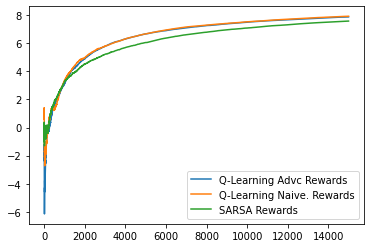

In [99]:
plt.plot([np.mean(q_t_rewards[:j]) for j in range(10,len(q_t_rewards))], label='Q-Learning Advc Rewards')
plt.plot([np.mean(q_n_rewards[:j]) for j in range(10,len(q_n_rewards))], label='Q-Learning Naive. Rewards')
plt.plot([np.mean(sarsa_rewards[:j]) for j in range(10,len(sarsa_rewards))], label='SARSA Rewards')
plt.legend()
plt.show()

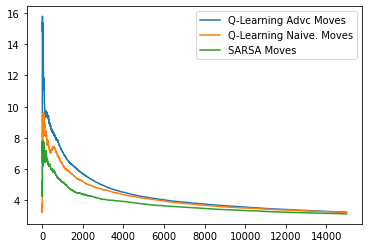

In [100]:
plt.plot([np.mean(q_t_moves[:j]) for j in range(10,len(q_t_moves))], label='Q-Learning Advc Moves')
plt.plot([np.mean(q_n_moves[:j]) for j in range(10,len(q_n_moves))], label='Q-Learning Naive. Moves')
plt.plot([np.mean(sarsa_moves[:j]) for j in range(10,len(sarsa_moves))], label='SARSA Moves')
plt.legend()
plt.show()

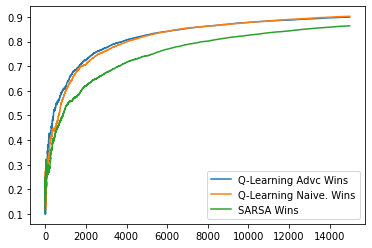

In [101]:
plt.plot([np.mean(q_t_wins[:j]) for j in range(10,len(q_t_wins))], label='Q-Learning Advc Wins')
plt.plot([np.mean(q_n_wins[:j]) for j in range(10,len(q_n_wins))], label='Q-Learning Naive. Wins')
plt.plot([np.mean(sarsa_wins[:j]) for j in range(10,len(sarsa_wins))], label='SARSA Wins')
plt.legend()
plt.show()